In [23]:
import numpy as np
import glob
from matplotlib.transforms import Bbox
from matplotlib.path import Path
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.image as mpimg

def isClosed(xs,ys):
    if np.alltrue([np.allclose(xs[0],xs[-1]),\
        np.allclose(ys[0],ys[-1]),xs.ptp(),ys.ptp()]):
        return True
    else:
        return False

def isContClosed(contour):
    x=contour.vertices[:, 0]
    y=contour.vertices[:, 1]
    return isClosed(x,y)

def polygonArea(x,y):
    if not isClosed(x,y):
        # here is a minor issue: isclosed() on lat/lon can be closed,
        # but after projection, unclosed. Happens to spurious small
        # contours usually a triangle. just return 0.
        return 0
    area=np.sum(y[:-1]*np.diff(x)-x[:-1]*np.diff(y))
    return np.abs(0.5*area)

def contourArea(contour):
    '''Compute area of contour
    <contour>: matplotlib Path obj, contour.
    Return <result>: float, area enclosed by <contour>.
    NOTE that <contour> is not necessarily closed by isClosed() method,
    it won't be when a closed contour has holes in it (like a doughnut). In such
    cases, areas of holes are subtracted.
    '''

    segs=contour.to_polygons()
    if len(segs)>1:
        areas=[]
        for pp in segs:
            xii=pp[:,0]
            yii=pp[:,1]
            areaii=polygonArea(xii,yii)
            areas.append(areaii)
        areas.sort()
        result=areas[-1]-np.sum(areas[:-1])
    else:
        x=contour.vertices[:, 0]
        y=contour.vertices[:, 1]
        result=polygonArea(x,y)

    return result

def polygonGeoArea(lons,lats,method='basemap',projection='cea',bmap=None,
        verbose=True):

    #------Use basemap to project coordinates------
    if method=='basemap':
        if bmap is None:
            from mpl_toolkits.basemap import Basemap

            lat1=np.min(lats)
            lat2=np.max(lats)
            lat0=np.mean(lats)
            lon1=np.min(lons)
            lon2=np.max(lons)
            lon0=np.mean(lons)

            if projection=='cea':
                bmap=Basemap(projection=projection,\
                        llcrnrlat=lat1,llcrnrlon=lon1,\
                        urcrnrlat=lat2,urcrnrlon=lon2)
            elif projection=='aea':
                bmap=Basemap(projection=projection,\
                        lat_1=lat1,lat_2=lat2,lat_0=lat0,lon_0=lon0,
                        llcrnrlat=lat1,llcrnrlon=lon1,\
                        urcrnrlat=lat2,urcrnrlon=lon2)

        xs,ys=bmap(lons,lats)

    #------Use pyproj to project coordinates------
    elif method=='proj':
        from pyproj import Proj

        lat1=np.min(lats)
        lat2=np.max(lats)
        lat0=np.mean(lats)
        lon0=np.mean(lons)

        pa=Proj('+proj=aea +lat_1=%f +lat_2=%f +lat_0=%f +lon_0=%f'\
                %(lat1,lat2,lat0,lon0))
        xs,ys=pa(lons,lats)

    result=polygonArea(xs,ys)

    return result

def contourGeoArea(contour,bmap=None):
    '''Compute area enclosed by latitude/longitude contour.
    Result in m^2
    '''

    segs=contour.to_polygons()
    if len(segs)>1:
        areas=[]
        for pp in segs:
            xii=pp[:,0]
            yii=pp[:,1]
            areaii=polygonGeoArea(xii,yii,bmap=bmap)
            areas.append(areaii)
        areas.sort()
        result=areas[-1]-np.sum(areas[:-1])
    else:
        x=contour.vertices[:, 0]
        y=contour.vertices[:, 1]
        result=polygonGeoArea(x,y,bmap=bmap)

    return result


def getProminence(var,step,lats=None,lons=None,min_depth=None,
        include_edge=True,
        min_area=None,max_area=None,area_func=contourArea,
        centroid_num_to_center=5,
        allow_hole=True,max_hole_area=None,
        verbose=False):

    fig,ax=plt.subplots()

    def checkIn(cont1,cont2,lon1,lon2,lat1,lat2):
        fails=[]
        vs2=cont2.vertices
        for ii in range(len(vs2)):
            if not cont1.contains_point(vs2[ii]) and\
                not np.isclose(vs2[ii][0],lon1) and\
                not np.isclose(vs2[ii][0],lon2) and\
                not np.isclose(vs2[ii][1],lat1) and\
                not np.isclose(vs2[ii][1],lat2):
                fails.append(vs2[ii])
            if len(fails)>0:
                break
        return fails

    var=np.ma.masked_where(np.isnan(var),var).astype('float')
    needslerpx=True
    needslerpy=True
    if lats is None:
        lats=np.arange(var.shape[0])
        needslerpy=False
    if lons is None:
        lons=np.arange(var.shape[1])
        needslerpx=False

    if area_func==contourGeoArea:
        from mpl_toolkits.basemap import Basemap
        lat1=np.min(lats)
        lat2=np.max(lats)
        lon1=np.min(lons)
        lon2=np.max(lons)

        bmap=Basemap(projection='cea',\
                llcrnrlat=lat1,llcrnrlon=lon1,\
                urcrnrlat=lat2,urcrnrlon=lon2)

    vmax=np.nanmax(var)
    vmin=np.nanmin(var)
    step=abs(step)
    levels=np.arange(vmin,vmax+step,step).astype('float')

    npeak=0
    peaks={}
    prominence={}
    parents={}

    #----------------Get bounding box----------------
    #bbox=Bbox.from_bounds(lons[0],lats[0],np.ptp(lons),np.ptp(height))
    bbox=Path([[lons[0],lats[0]], [lons[0],lats[-1]],
        [lons[-1],lats[-1]], [lons[-1],lats[0]], [lons[0], lats[0]]])

    #If not allow unclosed contours, get all contours in one go
    if not include_edge:
        conts=ax.contour(lons,lats,var,levels)
        contours=conts.collections[::-1]
        got_levels=conts.cvalues
        if not np.all(got_levels==levels):
            levels=got_levels
        ax.cla()

    large_conts=[]

    #---------------Loop through levels---------------
    for ii,levii in enumerate(levels[::-1]):
        if verbose:
            print('# <getProminence>: Finding contour %f' %levii)

        #-Get a 2-level contour if allow unclosed contours-
        if include_edge:
            csii=ax.contourf(lons,lats,var,[levii,vmax+step])
            csii=csii.collections[0]
            ax.cla()
        else:
            csii=contours[ii]

        #--------------Loop through contours at level--------------
        for jj, contjj in enumerate(csii.get_paths()):

            contjj.level=levii
            #contjj.is_edge=contjj.intersects_bbox(bbox,False) # False significant
            # this might be another matplotlib bug, intersects_bbox() used
            # to work
            contjj.is_edge=contjj.intersects_path(bbox,False) # False significant

            # NOTE: contjj.is_edge==True is NOT equivalent to
            # isContClosed(contjj)==False, unclosed contours inside boundaries
            # can happen when missings are present

            if not include_edge and contjj.is_edge:
                continue

            if not include_edge and not isContClosed(contjj):
                # Sometimes contours are not closed
                # even if not touching edge, this happens when missings
                # are present. In such cases, need to close it before
                # computing area. But even so, unclosed contours won't
                # contain any other, so might well just skip it.
                # the contourf() approach seems to be more robust in such 
                # cases.
                continue

            #--------------------Check area--------------------
            # if contour contains a big contour, skip area computation
            area_big=False
            for cii in large_conts:
                if contjj.contains_path(cii):
                    area_big=True
                    break

            if area_big:
                continue

            if area_func==contourGeoArea:
                contjj.area=area_func(contjj,bmap=bmap)/1e6
            else:
                contjj.area=area_func(contjj)

            if max_area is not None and contjj.area>max_area:
                large_conts.append(contjj)
                continue

            #----------------Remove small holes----------------
            segs=contjj.to_polygons()
            if len(segs)>1:
                contjj.has_holes=True
                if not allow_hole:
                    continue
                else:
                    if max_hole_area is not None:
                        areas=[]
                        if area_func==contourGeoArea:
                            areas=[polygonGeoArea(segkk[:,0],segkk[:,1],\
                                bmap=bmap)/1e6 for segkk in segs]
                        else:
                            areas=[polygonArea(segkk[:,0],segkk[:,1])\
                                    for segkk in segs]
                        areas.sort()
                        if areas[-2]>=max_hole_area:
                            continue

            else:
                contjj.has_holes=False

            if len(peaks)==0:
                npeak+=1
                peaks[npeak]=[contjj,]
                prominence[npeak]=levii
                parents[npeak]=0
            else:
                #-Check if new contour contains any previous ones-
                match_list=[]
                for kk,vv in peaks.items():
                    if contjj.contains_path(vv[-1]):
                        match_list.append(kk)
                    else:
                        # this is likely a bug in matplotlib. The contains_path()
                        # function is not entirely reliable when contours are
                        # touching the edge and step is small. Sometimes
                        # enclosing contours will fail the test. In such cases
                        # check all the points in cont2 with cont1.contains_point()
                        # if no more than 2 or 3 points failed, it is a pass.
                        # see https://stackoverflow.com/questions/47967359/matplotlib-contains-path-gives-unstable-results for more details.
                        # UPDATE: I've changed the method when 2
                        # contours compared are touching the edge: it seems that
                        # sometimes all points at the edge will fail so the
                        # failed number can go above 10 or even more. The new
                        # method compares the number of points that fail the contains_point()
                        # check with points at the edge. If all failing points are
                        # at the edge,report a contain relation
                        fail=checkIn(contjj,vv[-1],lons[0],lons[-1],lats[0],
                                lats[-1])
                        if len(fail)==0:
                            match_list.append(kk)

                #---------Create new center if non-overlap---------
                if len(match_list)==0:
                    npeak+=1
                    peaks[npeak]=[contjj,]
                    prominence[npeak]=levii
                    parents[npeak]=0

                elif len(match_list)==1:
                    peaks[match_list[0]].append(contjj)

                else:
                    #------------------Filter by area------------------
                    if min_area is not None and len(match_list)>1:
                        match_list2=[]
                        for mm in match_list:
                            areamm=peaks[mm][-1].area
                            if areamm<min_area:
                                print (match_list)
                                print ('del by area',mm)
                                del peaks[mm]
                                del prominence[mm]
                                if mm in parents:
                                    del parents[mm]
                            else:
                                match_list2.append(mm)

                        match_list=match_list2

                    #------------------Get prominence------------------
                    if len(match_list)>1:
                        match_heights=[peaks[mm][0].level for mm in match_list]
                        max_idx=match_list[np.argmax(match_heights)]
                        for mm in match_list:
                            if prominence[mm]==peaks[mm][0].level and mm!=max_idx:
                                prominence[mm]=peaks[mm][0].level-levii
                                parents[mm]=max_idx
                        peaks[max_idx].append(contjj)

                    #---------------Filter by prominence---------------
                    if min_depth is not None and len(match_list)>1:
                        match_list2=[]
                        for mm in match_list:
                            if prominence[mm]<min_depth:
                                del peaks[mm]
                                del prominence[mm]
                                if mm in parents:
                                    del parents[mm]
                            else:
                                match_list2.append(mm)
                        match_list=match_list2

                    #-----------Add to all existing centers-----------
                    #for mm in match_list:
                        #peaks[mm].append(contjj)

    #------------------Prepare output------------------
    result={}
    result_map=np.zeros(var.shape)
    parent_map=np.zeros(var.shape)-1
    id_map=np.zeros(var.shape)

    keys=peaks.keys()
    for ii in range(len(peaks)):
        kk=list(keys)[ii]
        vv=peaks[kk]
        #--------------Remove singleton peaks--------------
        if len(vv)<2:
            continue
        
        lev_range=[cii.level for cii in vv]
        prokk=prominence[kk]

        #-------Use first few centroids to get center-------
        nc=min(centroid_num_to_center,len(vv))
        centerkk=np.array([jj.vertices.mean(axis=0) for jj in vv[:nc]])
        centerkk=np.mean(centerkk,axis=0)

        peakii={
            'id'         : kk,
            'height'  : np.max(lev_range),
            'col_level'  : np.min(lev_range),
            'prominence'  : prokk,
            'area'       : vv[-1].area,
            'contours'   : vv,
            'contour'    : vv[-1],
            'center'     : centerkk,
            'parent'     : parents[kk]
            }

        result[kk]=peakii
        # lerp1 to get center indices
        if needslerpx:
            fitx=interp1d(lons,np.arange(var.shape[1]))
            xidx=fitx(centerkk[0])
        else:
            xidx=centerkk[0]

        if needslerpy:
            fity=interp1d(lats,np.arange(var.shape[0]))
            yidx=fity(centerkk[1])
        else:
            yidx=centerkk[1]

        xidx=np.around(xidx,0).astype('int')
        yidx=np.around(yidx,0).astype('int')

        id_map[yidx,xidx]=kk
        result_map[yidx,xidx]=prokk
        parent_map[yidx,xidx]=parents[kk]

    plt.close(fig)

    return result, id_map, result_map, parent_map

In [ ]:
#------------------A toy example------------------
xx=np.linspace(-10,10,100)
yy=np.linspace(-10,10,100)

XX,YY=np.meshgrid(xx,yy)
slab=np.zeros(XX.shape)

# add 3 peaks
slab+=5*np.exp(-XX**2/1**2 - YY**2/1**2)
slab+=8*np.exp(-(XX-3)**2/2**2 - YY**2/2**2)
slab+=10*np.exp(-(XX+4)**2/2**2 - YY**2/2**2)

step=0.2
zmax=slab.max()
peaks,idmap,promap,parentmap=getProminence(slab,step,lats=yy,lons=xx,min_area=None,
        include_edge=True)
# print(promap)

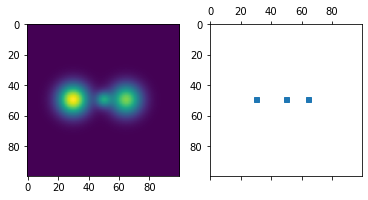

In [18]:
plt.subplot(1,2,1)
plt.imshow(slab)
plt.subplot(1,2,2)
plt.spy(promap, markersize=5)
plt.show()

In [70]:
savedPath = '/home/shared/DARPA/patched_category/point/training/seg_patches_converted/'
FileList = glob.glob(savedPath+'*.png')
firstfile = mpimg.imread(FileList[0])

In [71]:
xx=np.linspace(0,255,256)
yy=np.linspace(0,255,256)

In [72]:
peaks,idmap,promap,parentmap=getProminence(firstfile[:,:,0],0.2,lats=yy,lons=xx,min_area=None,include_edge=True)
# print(promap)

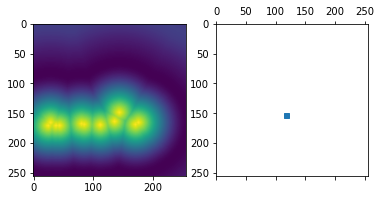

In [73]:
plt.subplot(1,2,1)
plt.imshow(firstfile[:,:,0])
plt.subplot(1,2,2)
plt.spy(promap, markersize=5)
plt.show()

In [74]:
sum(firstfile[:,:,0])

array([ 77.36074 ,  78.407814,  79.57645 ,  80.59998 ,  81.69802 ,
        82.749016,  83.8745  ,  84.86272 ,  85.901924,  86.90192 ,
        87.847   ,  88.86268 ,  89.77639 ,  90.666595,  91.4862  ,
        92.376396,  93.176414,  93.925446,  94.60388 ,  95.25488 ,
        95.90978 ,  96.50979 ,  97.0588  ,  97.50586 ,  97.921555,
        98.29018 ,  98.37645 ,  98.4039  ,  98.36077 ,  98.25489 ,
        97.89019 ,  97.46665 ,  97.27841 ,  97.30195 ,  97.30195 ,
        97.309784,  97.29409 ,  97.19606 ,  97.1333  ,  96.70978 ,
        96.27448 ,  95.81566 ,  95.83135 ,  95.831345,  95.7686  ,
        95.470566,  95.10194 ,  94.68625 ,  94.19213 ,  93.61567 ,
        93.05879 ,  92.52937 ,  91.88231 ,  91.24308 ,  90.5254  ,
        89.764626,  89.046974,  88.26267 ,  87.52935 ,  86.66661 ,
        86.05094 ,  85.462715,  85.148994,  85.121544,  85.39606 ,
        85.9333  ,  86.529366,  87.3568  ,  88.15679 ,  88.937164,
        89.65482 ,  90.40384 ,  91.090126,  91.71367 ,  92.321